<a href="https://colab.research.google.com/github/hellojohnkim/mmai891/blob/main/24_891_JohnKim_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MMAI 891: Individual Assignment

Version 1: Updated February 4, 2024

- John Kim
- 20439250
- MMAI 2024 891 NLP
- The Great Gatsby, F Scott Fitzgerald
- Due April 21, 2024

# Preliminaries: Inspect and Set up environment

In [1]:
import datetime
import pandas as pd
import numpy as np

In [2]:
print(datetime.datetime.now())

2024-04-21 19:04:16.726164


In [3]:
!which python

/usr/local/bin/python


In [4]:
!python --version

Python 3.10.12


In [5]:
!echo $PYTHONPATH

/env/python


In [ ]:
# TODO: install any packages you need to here. For example:
#pip install unidecode
!pip install optuna
!pip install accelerate -U transformers[torch] -U

# Question 1: Sentiment Analysis via Shallow ML



In [28]:
# DO NOT MODIFY THIS CELL

# First, we'll read the provided labeled training data
df = pd.read_csv("https://drive.google.com/uc?export=download&id=1b8MAiN-xBdk6scM-DnufkuijDZivZJqM")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2400 entries, 0 to 2399
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Sentence  2400 non-null   object
 1   Polarity  2400 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 37.6+ KB


In [29]:
# DO NOT MODIFY THIS CELL

# Next, we'll split it into training and test
from sklearn.model_selection import train_test_split

X = df['Sentence']
y = df['Polarity']

# So that we can evaluate how well our model is performing, we split our training data
# into training and validation.

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)

## Part 1.a: Preprocessing and FE Pipeline

In [30]:
# Step 1 - Import Libraries
#import nltk
#from nltk.tokenize import word_tokenize
#from nltk.corpus import stopwords
#import string
#from nltk.stem import WordNetLemmatizer
#import unicodedata
#from sklearn.feature_extraction.text import TfidfVectorizer
#from nltk import pos_tag
#import pandas as pd

# Step 2 - Define a function to clean text
def clean_text(text):
    # Normalize text
    text = unicodedata.normalize('NFKC', text)
    # Tokenize text
    tokens = word_tokenize(text)
    # Convert to lower case
    tokens = [w.lower() for w in tokens]
    # Remove punctuation
    table = str.maketrans('', '', string.punctuation)
    stripped = [w.translate(table) for w in tokens if w not in ['n\'t', 'not']]  # Preserve negations
    # Remove non-alphabetic tokens
    words = [word for word in stripped if word.isalpha() or word in ['n\'t', 'not']]  # Include negations
    # Filter out stop words
    stop_words = set(stopwords.words('english')) - {'not'}  # Remove 'not' from stop words to keep it in the analysis
    words = [w for w in words if not w in stop_words]
    return ' '.join(words)

# Step 3 - Extract POS Features and Length Features
def extract_features(text):
    # Tokenize and get POS tags
    tokens = word_tokenize(text)
    pos_tags = pos_tag(tokens)
    # Initialize counts
    features = {'ADJ': 0, 'ADV': 0, 'doc_length': len(tokens)}
    for _, tag in pos_tags:
        if tag.startswith('JJ'):
            features['ADJ'] += 1
        elif tag.startswith('RB'):
            features['ADV'] += 1
    return [features['ADJ'], features['ADV'], features['doc_length']]

# Step 4 - Clean and Prepare Training Data
X_train_cleaned = X_train.apply(clean_text)

# Step 5 - Vectorization and Feature Engineering
vectorizer = TfidfVectorizer(ngram_range=(1, 3))
X_train_tfidf = vectorizer.fit_transform(X_train_cleaned)

# Extract POS and length features and convert to DataFrame
feature_columns = pd.DataFrame(X_train.apply(extract_features).tolist(), columns=['Num_Adjectives', 'Num_Adverbs', 'Document_Length'])

# Combine TF-IDF features with POS features for the training set
X_train_features = pd.concat([pd.DataFrame(X_train_tfidf.toarray(), columns=vectorizer.get_feature_names_out()), feature_columns], axis=1)

# Apply the same cleaning and feature extraction to the validation data
X_val_cleaned = X_val.apply(clean_text)
X_val_tfidf = vectorizer.transform(X_val_cleaned)

# Repeat feature extraction for validation data
pos_features_val = pd.DataFrame(X_val.apply(extract_features).tolist(), columns=['Num_Adjectives', 'Num_Adverbs', 'Document_Length'])
X_val_features = pd.concat([pd.DataFrame(X_val_tfidf.toarray(), columns=vectorizer.get_feature_names_out()), pos_features_val], axis=1)

# Ensure all feature names are strings
X_train_features.columns = X_train_features.columns.astype(str)
X_val_features.columns = X_val_features.columns.astype(str)

In [26]:
# Step 1 - Import Libraries
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
from nltk.stem import WordNetLemmatizer
import unicodedata
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk import pos_tag
import pandas as pd

# Download necessary NLTK resources
nltk.download('punkt')  # Tokenizer Model
nltk.download('stopwords')  # Stopwords that are commonly omitted
nltk.download('wordnet')  # Database for the lemmatizer
nltk.download('averaged_perceptron_tagger')  # POS tagger model

# Step 2 - Define a function to clean text
def clean_text(text):
    # Normalize text to Unicode form to maintain consistency in encoding
    text = unicodedata.normalize('NFKC', text)
    # Tokenize text - splitting text into words or tokens
    tokens = word_tokenize(text)
    # Convert to lower case to standardize the case for text comparison
    tokens = [w.lower() for w in tokens]
    # Remove punctuation from each word to focus on the textual content
    table = str.maketrans('', '', string.punctuation)
    stripped = [w.translate(table) for w in tokens]
    # Remove non-alphabetic tokens to focus only on words
    words = [word for word in stripped if word.isalpha()]
    # Filter out stop words to remove commonly used words that may skew analysis
    stop_words = set(stopwords.words('english'))
    words = [w for w in words if not w in stop_words]
    return ' '.join(words)

# Step 3 - Extract POS Features
def extract_pos_features(text):
    # Tokenize the text and get POS tags
    tokens = word_tokenize(text)
    pos_tags = pos_tag(tokens)
    # Count adjectives and adverbs
    # as they often carry strong sentiment implications
    adj_adv_counts = {'ADJ': 0, 'ADV': 0}
    for _, tag in pos_tags:
        if tag.startswith('JJ'):  # Adjective
            adj_adv_counts['ADJ'] += 1
        elif tag.startswith('RB'):  # Adverb
            adj_adv_counts['ADV'] += 1
    return [adj_adv_counts['ADJ'], adj_adv_counts['ADV']]

# Step 4 - Clean and Prepare Training Data
X_train_cleaned = X_train.apply(clean_text)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [ ]:
# Step 5 - Vectorization and Feature Engineering
# Use TF-IDF to transform text into a meaningful representation of numbers which
# the model can understand, emphasizing words that are more unique to the context
vectorizer = TfidfVectorizer(ngram_range=(1, 3))  # Expanding n-gram range to capture context within tri-grams
X_train_tfidf = vectorizer.fit_transform(X_train_cleaned)

# Extract POS features and convert to DataFrame
# This enriches our model with syntactic information that can be crucial for understanding sentiment
pos_features = pd.DataFrame(X_train.apply(extract_pos_features).tolist(), columns=['Num_Adjectives', 'Num_Adverbs'])

# Combine TF-IDF features with POS features for the training set
X_train_features = pd.concat([pd.DataFrame(X_train_tfidf.toarray(), columns=vectorizer.get_feature_names_out()), pos_features], axis=1)

# Apply the same cleaning and feature extraction to the validation data
X_val_cleaned = X_val.apply(clean_text)
X_val_tfidf = vectorizer.transform(X_val_cleaned)

# Repeat feature extraction for validation data
pos_features_val = pd.DataFrame(X_val.apply(extract_pos_features).tolist(), columns=['Num_Adjectives', 'Num_Adverbs'])
X_val_features = pd.concat([pd.DataFrame(X_val_tfidf.toarray(), columns=vectorizer.get_feature_names_out()), pos_features_val], axis=1)

# Ensure all feature names are strings
X_train_features.columns = X_train_features.columns.astype(str)
X_val_features.columns = X_val_features.columns.astype(str)

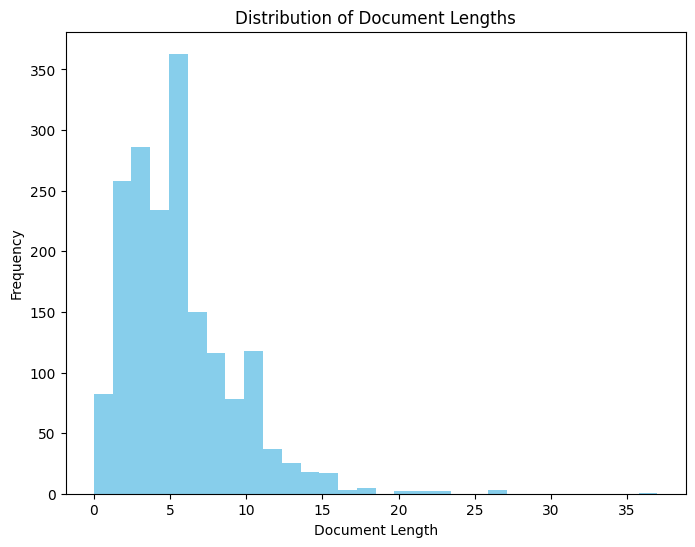

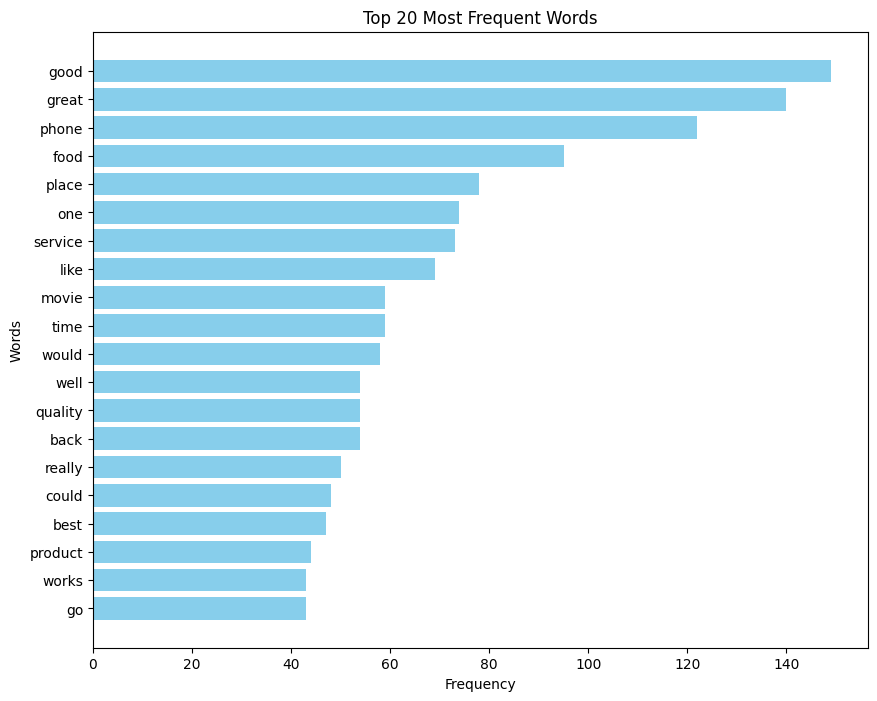

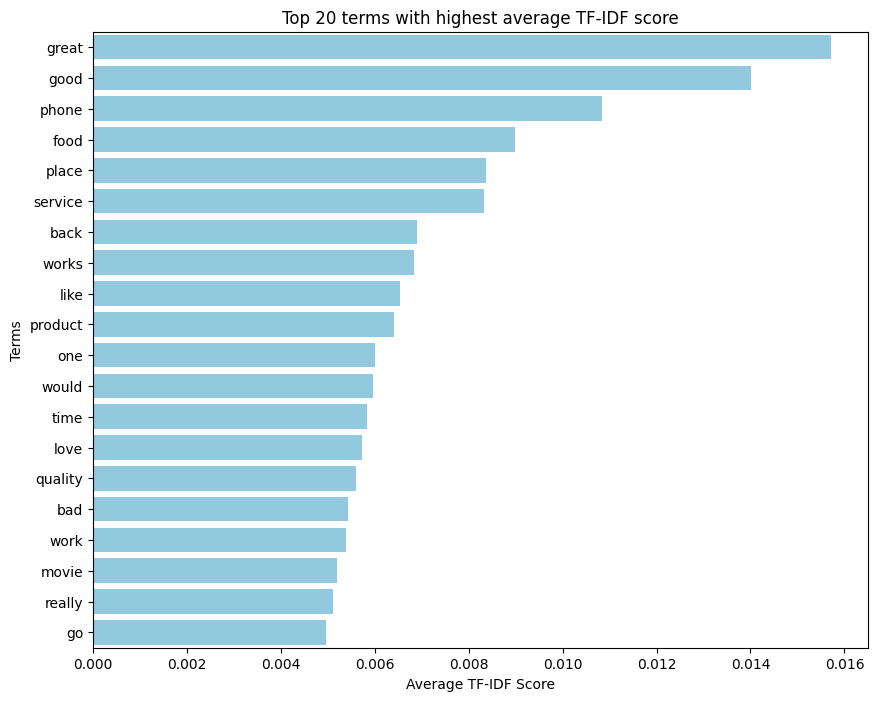

NameError: name 'pos_features' is not defined

In [31]:
# EDA Script 1: Visualize the distribution of document lengths
import matplotlib.pyplot as plt

doc_lengths = X_train_cleaned.apply(lambda x: len(x.split()))
plt.figure(figsize=(8,6))
plt.hist(doc_lengths, bins=30, color='skyblue')
plt.title('Distribution of Document Lengths')
plt.xlabel('Document Length')
plt.ylabel('Frequency')
plt.show()

# EDA Script 2: Word Frequency Analysis
from collections import Counter

# Flatten all the cleaned text into a list of words
all_words = [word for text in X_train_cleaned for word in text.split()]
word_freq = Counter(all_words)

# Top 20 words
common_words = word_freq.most_common(20)
words, counts = zip(*common_words)
plt.figure(figsize=(10, 8))
plt.barh(words, counts, color='skyblue')
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.title('Top 20 Most Frequent Words')
plt.gca().invert_yaxis()
plt.show()

# EDA Script 3: Visualize the distribution of TF-IDF values
import seaborn as sns

tfidf_df = pd.DataFrame(X_train_tfidf.toarray(), columns=vectorizer.get_feature_names_out())
tfidf_means = tfidf_df.mean(axis=0).sort_values(ascending=False)[:20]

plt.figure(figsize=(10, 8))
sns.barplot(x=tfidf_means.values, y=tfidf_means.index, color='skyblue')
plt.xlabel('Average TF-IDF Score')
plt.ylabel('Terms')
plt.title('Top 20 terms with highest average TF-IDF score')
plt.show()

# EDA Script 4: POS Tag Distribution
pos_counts = pos_features.sum(axis=0)
plt.figure(figsize=(8, 6))
pos_counts.plot(kind='bar', color='skyblue')
plt.title('Distribution of Part-of-Speech Tags')
plt.xlabel('POS Tag')
plt.ylabel('Frequency')
plt.xticks(rotation=0)
plt.show()


| Plot | Insights |
|------|-----------|
| **Distribution of Document Lengths** | Most documents have fewer than 10 words post-preprocessing. There's a risk of losing important sentiment context, which highlights the need to ensure preprocessing retains critical content. |
| **Top 20 Most Frequent Words** | Common words like "nt" (short for "not"), "good", and "great" indicate clear sentiment expressions. The presence of "nt" suggests the importance of handling negations carefully. |
| **Top 20 Terms with Highest Average TF-IDF Score** | Terms like "great", "good", and "bad" carry significant sentiment weight. The TF-IDF score emphasizes these words, which are crucial for the model to learn sentiment effectively. |
| **Distribution of Part-of-Speech Tags** | The balanced frequency of adjectives and adverbs, which are key to conveying sentiment, indicates that the model should consider these POS tags for nuanced sentiment analysis. |


## Part 1.b: Model Training/Tuning/Cross Validation

In [ ]:
import optuna
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import StackingClassifier
import joblib

# Prepare classifiers
log_reg = LogisticRegression(random_state=42, max_iter=100)
dtree = RandomForestClassifier(random_state=42, n_estimators=50, max_depth=5)
bagging = BaggingClassifier(estimator=dtree, n_estimators=5, random_state=42)
boosting = AdaBoostClassifier(n_estimators=50, random_state=42)
xgboost = XGBClassifier(objective='binary:logistic', random_state=42)

# Define an objective function to be minimized.
def objective(trial):
    # Hyperparameter setting
    xgb_params = {
        'max_depth': trial.suggest_int('xgb__max_depth', 3, 10),
        'learning_rate': trial.suggest_float('xgb__learning_rate', 0.01, 0.1),
        'n_estimators': trial.suggest_int('xgb__n_estimators', 50, 150),
        'scale_pos_weight': trial.suggest_categorical('xgb__scale_pos_weight', [1, sum(y_train == 0) / sum(y_train == 1)])
    }

    xgb = XGBClassifier(**xgb_params, random_state=42)

    # Stack classifiers
    estimators = [
        ('rf', dtree),
        ('bg', bagging),
        ('adb', boosting),
        ('xgb', xgb)
    ]
    stacking_clf = StackingClassifier(estimators=estimators, final_estimator=log_reg, stack_method='auto', n_jobs=-1)

    # Cross-validation scores
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(stacking_clf, X_train_features, y_train, cv=kf, scoring='accuracy')

    return scores.mean()

# Create an Optuna study object and optimize the objective function.
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

# Best trial
trial = study.best_trial
print(f'Accuracy: {trial.value}')
print("Best hyperparameters: {}".format(trial.params))

# Rebuild the model with the best parameters
xgb_best = XGBClassifier(**trial.params, objective='binary:logistic', random_state=42)
stacking_clf_best = StackingClassifier(estimators=[
        ('rf', dtree),
        ('bg', bagging),
        ('adb', boosting),
        ('xgb', xgb_best)
    ], final_estimator=log_reg, stack_method='auto', n_jobs=-1)

# Fit the best model
stacking_clf_best.fit(X_train_features, y_train)

# Save the model to disk
joblib.dump(stacking_clf_best, 'stacking_clf_best.joblib')

# Validate model
y_pred = stacking_clf_best.predict(X_val_features)
y_proba = stacking_clf_best.predict_proba(X_val_features)[:, 1]

[I 2024-04-21 19:18:43,066] A new study created in memory with name: no-name-33a6ee96-4771-4c96-99d6-38967c2aa87d
[I 2024-04-21 19:24:55,592] Trial 0 finished with value: 0.7188888888888888 and parameters: {'xgb__max_depth': 6, 'xgb__learning_rate': 0.021333862233324737, 'xgb__n_estimators': 146, 'xgb__scale_pos_weight': 0.978021978021978}. Best is trial 0 with value: 0.7188888888888888.
[I 2024-04-21 19:30:12,908] Trial 1 finished with value: 0.7166666666666666 and parameters: {'xgb__max_depth': 3, 'xgb__learning_rate': 0.0562533367498077, 'xgb__n_estimators': 119, 'xgb__scale_pos_weight': 0.978021978021978}. Best is trial 0 with value: 0.7188888888888888.
[I 2024-04-21 19:34:34,337] Trial 2 finished with value: 0.7244444444444446 and parameters: {'xgb__max_depth': 5, 'xgb__learning_rate': 0.09392142404521726, 'xgb__n_estimators': 73, 'xgb__scale_pos_weight': 1}. Best is trial 2 with value: 0.7244444444444446.
[I 2024-04-21 19:40:27,669] Trial 3 finished with value: 0.7172222222222222

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score , classification_report, confusion_matrix

# Evaluation metrics
accuracy = accuracy_score(y_val, y_pred)
precision, recall, f1, _ = precision_recall_fscore_support(y_val, y_pred, average='binary')
roc_auc = roc_auc_score(y_val, y_proba)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")
print(f"ROC-AUC: {roc_auc}")

Accuracy: 0.7833333333333333
Precision: 0.7692307692307693
Recall: 0.7581227436823105
F1-Score: 0.7636363636363637
ROC-AUC: 0.8645203473751271


## Part 1.c: Model Assessment


In [ ]:
# DO NOT MODIFY THIS CELL

test_df = pd.read_csv("https://drive.google.com/uc?export=download&id=1taoTluPBUMt9JkKAnlqDTrU49DJFpJGW")
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Sentence  600 non-null    object
 1   Polarity  600 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 9.5+ KB


In [ ]:
# Apply the clean_text function to clean the test data
test_df['cleaned_text'] = test_df['Sentence'].apply(clean_text)

# Transform the cleaned test text using the previously fitted TfidfVectorizer
X_test_tfidf = vectorizer.transform(test_df['cleaned_text'])

# Extract POS features from the test data
pos_features_test = pd.DataFrame(test_df['cleaned_text'].apply(extract_pos_features).tolist(), columns=['Num_Adjectives', 'Num_Adverbs'])

# Combine TF-IDF features with POS features for the test set
X_test_features = pd.concat([pd.DataFrame(X_test_tfidf.toarray(), columns=vectorizer.get_feature_names_out()), pos_features_test], axis=1)

# Ensure all feature names are strings to avoid sklearn processing errors
X_test_features.columns = X_test_features.columns.astype(str)

# Use the model to predict the transformed test data
try:
    y_test_pred = stacking_clf_best.predict(X_test_features)
    y_test_proba = stacking_clf_best.predict_proba(X_test_features)[:, 1]

    # Calculate and print metrics
    accuracy = accuracy_score(test_df['Polarity'], y_test_pred)
    precision = precision_score(test_df['Polarity'], y_test_pred)
    recall = recall_score(test_df['Polarity'], y_test_pred)
    f1 = f1_score(test_df['Polarity'], y_test_pred)
    roc_auc = roc_auc_score(test_df['Polarity'], y_test_proba)

    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")
    print(f"ROC AUC: {roc_auc}")
except Exception as e:
    print(f"An error occurred: {e}")

Accuracy: 0.6933333333333334
Precision: 0.7471264367816092
Recall: 0.6230031948881789
F1 Score: 0.6794425087108015
ROC AUC: 0.7799646001936972


## Part 2: Given the performance of your model, are you satisfied with the results?

| Metric    | Validation Score | Test Score     |
|-----------|------------------|----------------|
| Accuracy  | 0.7833           | 0.6933         |
| Precision | 0.7692           | 0.7471         |
| Recall    | 0.7581           | 0.6230         |
| F1-Score  | 0.7636           | 0.6794         |
| ROC-AUC   | 0.8645           | 0.7800         |

The disparity between the validation and test scores suggests possible overfitting in the model. The accuracy on the test set is significantly lower than on the validation set, highlighting the model's inability to generalize effectively to unseen data. The precision of 74.71% on the test set, while comparatively stable, still underscores the need for more precise predictions. Most notably, the recall of 62.30% on the test set suggests that the model fails to identify a considerable number of true positive cases, which is critical in many practical applications.

For more satisfaction, I would have incporated more advanced NLP techniques and domain-specific features, perhaps from the EDA stage, which could have enhanced the model's understanding and representation of the data. Additionally, employing a more robust hyperparameter optimization strategy and experimenting with different, simpler and complex, ensemble methods could improve the model's accuracy and generalization capabilities. Implementing regularizations and adjustments based on the discrepancy between training and validation scores may also prove beneficial.

## Part 3: Show five test instances in which your model was incorrect. Dive deep and find out why your model was wrong.

In [ ]:
##Step 1: Identify Misclassified Instances

# Add predictions to the test dataframe
test_df['predicted_polarity'] = y_test_pred

# Find instances where the predicted polarity does not match the actual polarity
misclassified = test_df[test_df['Polarity'] != test_df['predicted_polarity']]


In [ ]:
#Step 2: Display Five Misclassified Instances
# Randomly select 5 misclassified instances. #Analyzed answers are provided in the markdown table in the text box below.
misclassified_samples = misclassified.sample(n=5, random_state=42)
print(misclassified_samples)

                                              Sentence  Polarity  \
87   Lifetime does not air it enough, so if anyone ...         1   
178  With the originality and freshness of the firs...         0   
531  I do not know if this was Emilio Estevez's dir...         1   
394                Predictable, but not a bad watch.           1   
505  One of the most boring,pointless movies I have...         0   

                                          cleaned_text  predicted_polarity  
87   lifetime air enough anyone knows store sells l...                   0  
178  originality freshness first movie spent remake...                   1  
531  know emilio estevez directorial debut pacing i...                   0  
394                              predictable bad watch                   0  
505              one boring pointless movies ever seen                   1  


|index|Sentence|Polarity|cleaned\_text|predicted\_polarity|
|---|---|---|---|---|
|87|Lifetime does not air it enough, so if anyone knows what store sells it let me know because this is a must-have\.  |1|lifetime air enough anyone knows store sells let know musthave|0|
|178|With the originality and freshness of the first movie now spent, this remake had little else to offer\.  |0|originality freshness first movie spent remake little else offer|1|
|531|I do not know if this was Emilio Estevez's directorial debut, but the pacing, the interplay and development of the characters as well as some clever camera work surrounding the character Estevez plays all suggest a natural eye\.  |1|know emilio estevez directorial debut pacing interplay development characters well clever camera work surrounding character estevez plays suggest natural eye|0|
|394|Predictable, but not a bad watch\.  |1|predictable bad watch|0|
|505|One of the most boring,pointless movies I have ever seen\.  |0|one boring pointless movies ever seen|1|

| Index # |  Analysis                                                                                      |
|-------|------------------------------------------------------------------------------------------------------------------|
| 87    | Mixed sentiments with negative ("not enough") and strong positive desire ("must-have"). Model likely missed the key positive phrase. |
| 178   | Sentence carries a negative sentiment ("little else to offer") despite positive words ("originality", "freshness"). Model might have misinterpreted the positive words. |
| 531   | Uncertainty (I do not know) contrasts with praise for film elements (positive). This complexity may have confused the model. |
| 394   | "Predictable" hints at negative sentiment but is mitigated by "not a bad watch" (mildly positive). Model may have overemphasized the word "Predictable". |
| 505   | Clearly negative sentiment misclassified as positive. Could have been caused by training data imbalance or misinterpretation of the phrase "one of the most". |


# Question 2: Conceptual Understanding of the SOTA


## Part 1: What is transfer learning and fine-tuning in NLP? What advantages does it have over training from scratch?


Transfer learning is a technique where a pre-trained model is used as a starting ingredient in building an NLP model. The pre-trained model, which has already learned patterns and representations from large-scale data, can be useful for the model.
Fine-tuning, which involves training the pre-existing model on a new, smaller dataset specific to the task at hand, is then applied. This process "fine-tunes" the model for the new task, adjusting the pre-trained parameters to be more relevant and effective for the specific NLP problem. Transfer learning’s advantages include:

-	It saves time and computational resources compared to training from scratch
- Pre-trained models have already learned rich representations, so fine-tuning can be done on smaller datasets and still achieve good results.
-	Transfer learning often leads to improved model performance, as the pre-trained model can provide a good initialization point.
-	Transfer learning allows for faster experimentation and deployment.

chracter count: 947

## Part 2: What is a Large Language Model (LLM) and what are their strengths and weaknesses?


A Large Language Model (LLM) is a type of neural network model that has been trained on vast amounts of text data, often containing billions or even trillions of parameters. LLMs have revolutionized NLP tasks due to their ability to capture complex linguistic patterns and generate human-like responses.


Strengths:
- LLMs excel at generating coherent and contextually appropriate text, making them useful for a range of language tasks.
- They can provide detailed and nuanced responses, especially when fine-tuned for specific domains.
- Their capacity to understand and generate human languag can often make interactions feel natural.

Weaknesses:
- LLM has tendency to "hallucinate" or generate factually inaccurate information.
- They can require significant computational resources for training and deployment.
- LLMs can struggle with certain tasks that require specialized knowledge or common-sense reasoning, despite their vast training data.

940 characters

# Question 3 (Optional/Bonus): Sentiment Analysis via Deep ML


In [ ]:
# DO NOT MODIFY THIS CELL

# First, we'll read the provided labeled training data
df = pd.read_csv("https://drive.google.com/uc?export=download&id=1b8MAiN-xBdk6scM-DnufkuijDZivZJqM")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2400 entries, 0 to 2399
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Sentence  2400 non-null   object
 1   Polarity  2400 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 37.6+ KB


In [ ]:
# DO NOT MODIFY THIS CELL

# Next, we'll split it into training and test
from sklearn.model_selection import train_test_split

X = df['Sentence']
y = df['Polarity']

# So that we can evaluate how well our model is performing, we split our training data
# into training and validation.

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)

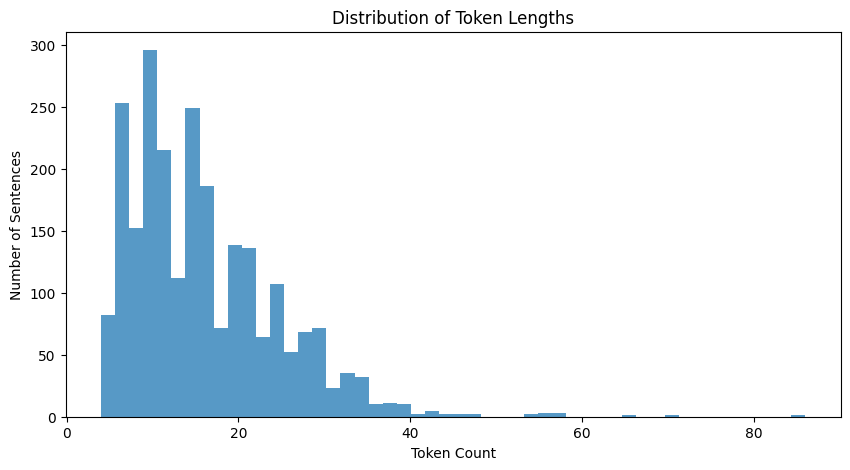

Percentiles:
90% of the lengths are below: 28.0
95% of the lengths are below: 32.0
99% of the lengths are below: 40.00999999999976


In [ ]:
import matplotlib.pyplot as plt

# Assuming 'tokenizer' is already loaded as DistilBertTokenizerFast
def compute_length(texts):
    return [len(tokenizer.encode(text, add_special_tokens=True)) for text in texts]

# Compute lengths
lengths = compute_length(X)

# Plotting the distribution of lengths
plt.figure(figsize=(10, 5))
plt.hist(lengths, bins=50, alpha=0.75)
plt.title('Distribution of Token Lengths')
plt.xlabel('Token Count')
plt.ylabel('Number of Sentences')
plt.show()

# Analyze the percentiles to choose a max_length
import numpy as np
print("Percentiles:")
print("90% of the lengths are below:", np.percentile(lengths, 90))
print("95% of the lengths are below:", np.percentile(lengths, 95))
print("99% of the lengths are below:", np.percentile(lengths, 99))


## Preprocessing

In [ ]:
from datasets import Dataset
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification, Trainer, TrainingArguments

# Load the tokenizer
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

# Function to tokenize the dataset
def tokenize_function(examples):
    # Now using max_length of 40 as determined from the percentile analysis
    return tokenizer(
        examples['Sentence'],
        padding="max_length",
        truncation=True,
        max_length=40  # Using the 99th percentile value
    )

# Convert the Pandas dataframes to Hugging Face dataset format
train_dataset = Dataset.from_pandas(df.iloc[X_train.index])
val_dataset = Dataset.from_pandas(df.iloc[X_val.index])

# Apply the tokenize function and remove original columns
train_dataset = train_dataset.map(tokenize_function, batched=True, remove_columns=['Sentence', 'Polarity'])
val_dataset = val_dataset.map(tokenize_function, batched=True, remove_columns=['Sentence', 'Polarity'])

# Add a column for labels as per Hugging Face Trainer requirement
train_dataset = train_dataset.add_column("labels", y_train.tolist())
val_dataset = val_dataset.add_column("labels", y_val.tolist())


Map:   0%|          | 0/1800 [00:00<?, ? examples/s]

Map:   0%|          | 0/600 [00:00<?, ? examples/s]

In [ ]:
from transformers import DistilBertForSequenceClassification, Trainer, TrainingArguments

# Load pre-trained model
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Model training

In [ ]:
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=3,              # number of training epochs
    per_device_train_batch_size=16,  # batch size for training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
)

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset
)

# Start training
trainer.train()


Step,Training Loss
10,0.697500
20,0.699400
30,0.688400
40,0.693100
50,0.686500
60,0.673100
70,0.671000
80,0.647900
90,0.556200
100,0.462500


TrainOutput(global_step=339, training_loss=0.3216411561037587, metrics={'train_runtime': 24.913, 'train_samples_per_second': 216.754, 'train_steps_per_second': 13.607, 'total_flos': 55884683808000.0, 'train_loss': 0.3216411561037587, 'epoch': 3.0})

In [ ]:
#Step 6: Evaluation
#Evaluate the model on the validation set to see how well it performs.


results = trainer.evaluate()
print(results)


{'eval_loss': 0.2447122186422348, 'eval_runtime': 0.6715, 'eval_samples_per_second': 893.463, 'eval_steps_per_second': 14.891, 'epoch': 3.0}


In [ ]:
#Step 7: Save the Model
#After training, save the model and the tokenizer for later use.

model_path = "./sentiment-distilbert-model"
model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)



('./sentiment-distilbert-model/tokenizer_config.json',
 './sentiment-distilbert-model/special_tokens_map.json',
 './sentiment-distilbert-model/vocab.txt',
 './sentiment-distilbert-model/added_tokens.json',
 './sentiment-distilbert-model/tokenizer.json')

In [ ]:
# Get predictions
predictions = trainer.predict(val_dataset)

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, confusion_matrix

# Extract logits
logits = predictions.predictions

# Convert logits to probabilities using softmax
probabilities = np.exp(logits) / np.sum(np.exp(logits), axis=1, keepdims=True)

# Extract predicted labels
predicted_labels = np.argmax(logits, axis=1)

# Extract True labels
true_labels = np.array(val_dataset["labels"])


In [ ]:
# Accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
print(f"Accuracy: {accuracy}")

# ROC-AUC
if len(np.unique(true_labels)) == 2:
    auc = roc_auc_score(true_labels, probabilities[:, 1])
    print(f"AUC: {auc}")
else:
    print("AUC is not applicable for non-binary classification tasks.")

# F1-Score
f1 = f1_score(true_labels, predicted_labels, average='weighted')
print(f"F1-Score: {f1}")

# Confusion Matrix
cm = confusion_matrix(true_labels, predicted_labels)
print("Confusion Matrix:")
print(cm)


Accuracy: 0.9333333333333333
AUC: 0.9788534832515563
F1-Score: 0.9333154410449096
Confusion Matrix:
[[304  19]
 [ 21 256]]


In [ ]:
from sklearn.metrics import classification_report
report = classification_report(true_labels, predicted_labels)
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       323
           1       0.93      0.92      0.93       277

    accuracy                           0.93       600
   macro avg       0.93      0.93      0.93       600
weighted avg       0.93      0.93      0.93       600



## Model Assessment

In [ ]:
# DO NOT MODIFY THIS CELL

test_df = pd.read_csv("https://drive.google.com/uc?export=download&id=1taoTluPBUMt9JkKAnlqDTrU49DJFpJGW")
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Sentence  600 non-null    object
 1   Polarity  600 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 9.5+ KB


In [ ]:
from datasets import Dataset
from transformers import DistilBertTokenizerFast
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score, classification_report, confusion_matrix

# Tokenize the test set
def tokenize_function(examples):
    return tokenizer(
        examples['Sentence'],
        padding="max_length",
        truncation=True,
        max_length=40
    )

# Convert the test dataframe to a Hugging Face dataset format
test_dataset = Dataset.from_pandas(test_df)

# Apply the tokenize function and remove original columns
test_dataset = test_dataset.map(tokenize_function, batched=True, remove_columns=['Sentence'])

# Predict using the trained model
test_predictions = trainer.predict(test_dataset)

# Extract logits from the predictions
test_logits = test_predictions.predictions

# Convert logits to probabilities using softmax
test_probabilities = np.exp(test_logits) / np.sum(np.exp(test_logits), axis=1, keepdims=True)

# Extract predicted labels
test_predicted_labels = np.argmax(test_logits, axis=1)

# Extract true labels
test_true_labels = test_df['Polarity'].to_numpy()

# Calculate accuracy
test_accuracy = accuracy_score(test_true_labels, test_predicted_labels)
print(f"Test Accuracy: {test_accuracy}")

# Calculate precision, recall, and F1-score
precision, recall, f1, _ = precision_recall_fscore_support(test_true_labels, test_predicted_labels, average='binary')
print(f"Precision: {precision}, Recall: {recall}, F1-Score: {f1}")

# Calculate ROC-AUC
test_auc = roc_auc_score(test_true_labels, test_probabilities[:, 1])  # Probabilities for the positive class
print(f"Test AUC: {test_auc}")

# Print classification report
print("Classification Report:")
print(classification_report(test_true_labels, test_predicted_labels))

# Print confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(test_true_labels, test_predicted_labels))


Map:   0%|          | 0/600 [00:00<?, ? examples/s]

Test Accuracy: 0.8983333333333333
Precision: 0.9315068493150684, Recall: 0.8690095846645367, F1-Score: 0.8991735537190082
Test AUC: 0.9617058699112779
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.93      0.90       287
           1       0.93      0.87      0.90       313

    accuracy                           0.90       600
   macro avg       0.90      0.90      0.90       600
weighted avg       0.90      0.90      0.90       600

Confusion Matrix:
[[267  20]
 [ 41 272]]


| Metric    | Shallow ML (Q1) | Deep ML (Q3)   |
|-----------|-----------------|----------------|
| Accuracy  | 0.6933          | 0.8983         |
| Precision | 0.7471          | 0.9315         |
| Recall    | 0.6230          | 0.8690         |
| F1 Score  | 0.6794          | 0.8992         |
| ROC AUC   | 0.7800          | 0.9617         |


The comparison clearly shows that the Deep ML model outperforms the Shallow ML model across all metrics. The significant improvement in ROC AUC indicates that the Deep ML model is much better at distinguishing between the classes. Higher precision and recall suggest that the Deep ML model is more accurate and reliable in identifying the correct sentiment, resulting in a higher F1 score, which is a measure of a test's accuracy. The improved performance is likely due to the deep learning model's ability to capture complex patterns and relationships in the data that the shallow model cannot.

In [ ]:
def colab2pdf():
    ENABLE=True # @param {type:"boolean"}
    if ENABLE:
        !apt-get install librsvg2-bin
        import os, datetime, json, locale, pathlib, urllib, requests, werkzeug, nbformat, google, yaml, warnings
        locale.setlocale(locale.LC_ALL, 'en_US.UTF-8')
        NAME = pathlib.Path(werkzeug.utils.secure_filename(urllib.parse.unquote(requests.get(f"http://{os.environ['COLAB_JUPYTER_IP']}:{os.environ['KMP_TARGET_PORT']}/api/sessions").json()[0]["name"])))
        TEMP = pathlib.Path("/content/pdfs") / f"{datetime.datetime.now().strftime('%Y%m%d_%H%M%S')}_{NAME.stem}"; TEMP.mkdir(parents=True, exist_ok=True)
        NB = [cell for cell in nbformat.reads(json.dumps(google.colab._message.blocking_request("get_ipynb", timeout_sec=600)["ipynb"]), as_version=4).cells if "--Colab2PDF" not in cell.source]
        warnings.filterwarnings('ignore', category=nbformat.validator.MissingIDFieldWarning)
        with (TEMP / f"{NAME.stem}.ipynb").open("w", encoding="utf-8") as nb_copy: nbformat.write(nbformat.v4.new_notebook(cells=NB or [nbformat.v4.new_code_cell("#")]), nb_copy)
        if not pathlib.Path("/usr/local/bin/quarto").exists():
            !wget -q "https://quarto.org/download/latest/quarto-linux-amd64.deb" -P {TEMP} && dpkg -i {TEMP}/quarto-linux-amd64.deb > /dev/null && quarto install tinytex --update-path --quiet
        with (TEMP / "config.yml").open("w", encoding="utf-8") as file: yaml.dump({'include-in-header': [{"text": r"\usepackage{fvextra}\DefineVerbatimEnvironment{Highlighting}{Verbatim}{breaksymbolleft={},showspaces=false,showtabs=false,breaklines,breakanywhere,commandchars=\\\{\}}"}],'include-before-body': [{"text": r"\DefineVerbatimEnvironment{verbatim}{Verbatim}{breaksymbolleft={},showspaces=false,showtabs=false,breaklines}"}]}, file)
        !quarto render {TEMP}/{NAME.stem}.ipynb --metadata-file={TEMP}/config.yml --to pdf -M latex-auto-install -M margin-top=1in -M margin-bottom=1in -M margin-left=1in -M margin-right=1in --quiet
        google.colab.files.download(str(TEMP / f"{NAME.stem}.pdf"))

In [ ]:
colab2pdf()

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  librsvg2-bin
0 upgraded, 1 newly installed, 0 to remove and 45 not upgraded.
Need to get 1,871 kB of archives.
After this operation, 6,019 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 librsvg2-bin amd64 2.52.5+dfsg-3ubuntu0.2 [1,871 kB]
Fetched 1,871 kB in 1s (2,233 kB/s)
Selecting previously unselected package librsvg2-bin.
(Reading database ... 131015 files and directories currently installed.)
Preparing to unpack .../librsvg2-bin_2.52.5+dfsg-3ubuntu0.2_amd64.deb ...
Unpacking librsvg2-bin (2.52.5+dfsg-3ubuntu0.2) ...
Setting up librsvg2-bin (2.52.5+dfsg-3ubuntu0.2) ...
Processing triggers for man-db (2.10.2-1) ...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>